Loaded technologies data with 238 entries
Total StackOverflow Concepts (including abbreviations): 320
Loaded existing concept embeddings from stack_concept_embeddings_sentence-transformers_msmarco-distilbert-base-v4.npy
Graph contains 312 nodes and 30 edges.
Total candidate phrases generated: 98
Total recognized candidate matches: 35
Global filtering completed.

Globally Filtered Recognized Concepts using sentence-transformers/msmarco-distilbert-base-v4 model:
Concept: Node.js (Abbreviation)
    Detected 1-gram: 'node' with similarity 1.00
------------------------------------------------------------
Concept: React (Technology)
    Detected 1-gram: 'react' with similarity 1.00
------------------------------------------------------------
Concept: Microsoft SQL Server (Abbreviation)
    Detected 1-gram: 'mssql' with similarity 1.00
------------------------------------------------------------
Concept: Objective-C (Abbreviation)
    Detected 1-gram: 'objc' with similarity 1.00
-------------

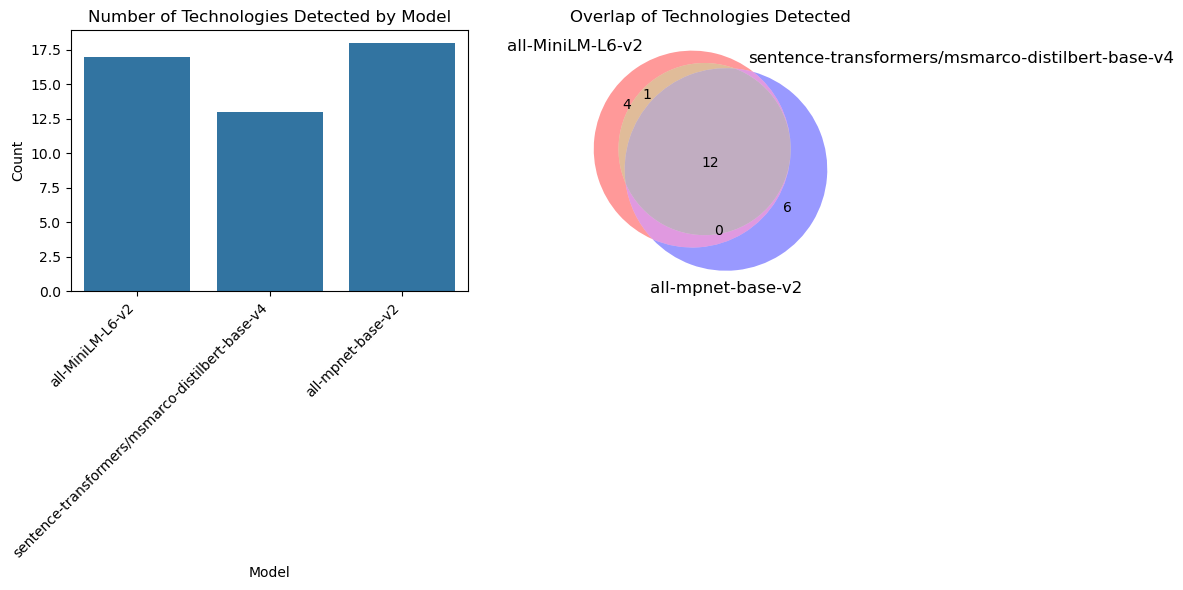


Technology Detection Comparison Across Models:
                   Technology all-MiniLM-L6-v2  \
0   Amazon Web Services (AWS)                ✓   
1                         C++                ✓   
2                  Cloudflare                    
3                  Databricks                    
4                     Datomic                ✓   
5                      Drupal                ✓   
6                Google Cloud                ✓   
7         IBM Cloud Or Watson                ✓   
8             Microsoft Azure                    
9        Microsoft SQL Server                ✓   
10                    Node.js                ✓   
11                Objective-C                ✓   
12                 PlatformIO                ✓   
13                     Python                ✓   
14                Rasberry Pi                ✓   
15                      React                ✓   
16                     Render                    
17               Scikit-Learn                ✓   
18

In [3]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
import networkx as nx
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
import warnings
warnings.filterwarnings('ignore')

# Ensure required NLTK resources are available.
# nltk.download('punkt')
# nltk.download('stopwords')

class ConceptMatcher:
    def __init__(
        self,
        csv_path="../../data/processed/technologies_with_abbreviations.csv",  # Updated path to new CSV with abbreviations
        columns=None,
        model_name="all-mpnet-base-v2",
        similarity_threshold_graph=0.7,
        ngram_threshold=0.5,
        filter_similarity_threshold=0.85
    ):
        if columns is None:
            columns = [
                "LanguageHaveWorkedWith", "DatabaseHaveWorkedWith", "PlatformHaveWorkedWith",
                "WebframeHaveWorkedWith", 
                "ToolsTechHaveWorkedWith"
            ]
        self.csv_path = csv_path
        self.columns = columns
        self.model_name = model_name
        self.similarity_threshold_graph = similarity_threshold_graph
        self.ngram_threshold = ngram_threshold
        self.filter_similarity_threshold = filter_similarity_threshold

        # Initialize NLTK stop words and custom filter words.
        self.stop_words = set(stopwords.words('english'))
        self.custom_filter_words = {
            'additionally', 'also', 'furthermore', 'moreover', 'including', 'like', 'career', 'etc'
        }

        # Initialize the SentenceTransformer model.
        self.model = SentenceTransformer(self.model_name)

        # Placeholders for later processing.
        self.tech_data = None          # DataFrame to store technology names and abbreviations
        self.stack_concepts = []       # List of concept dictionaries.
        self.concept_embeddings = None # Numpy array of concept embeddings.
        self.candidate_phrases = []    # Candidate n‑gram phrases from input text.
        self.candidate_embeddings = None  # Numpy array of candidate embeddings.
        self.recognized_candidates_ngram = []  # Matched candidates with similarity scores.
        self.filtered_by_concept = {}     # Final grouped output after global filtering.
        self.graph = None                 # Optional similarity graph.

    def clean_text(self, text):
        """
        Lowercase the text and remove punctuation except for hyphens and parentheses.
        """
        # Preserve '-' and parentheses by removing other punctuation.
        punctuation_to_remove = "".join(ch for ch in string.punctuation if ch not in "-(-)")
        text = text.lower().translate(str.maketrans("", "", punctuation_to_remove))
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in self.stop_words]
        return " ".join(tokens)

    def is_meaningful(self, phrase):
        tokens = [t.lower() for t in word_tokenize(phrase) if t.isalpha()]
        if not tokens:
            return False
        if any(token in self.custom_filter_words for token in tokens):
            return False
        if len(tokens) == 1 and tokens[0] in self.stop_words:
            return False
        if tokens and sum(1 for t in tokens if t in self.stop_words) / len(tokens) > 0.5:
            return False
        return True

    def load_concepts(self):
        # Load the technology data with abbreviations
        self.tech_data = pd.read_csv(self.csv_path)
        print(f"Loaded technologies data with {len(self.tech_data)} entries")
        
        # Create concepts from both technology names and their abbreviations
        self.stack_concepts = []
        
        # Add technology names first
        for _, row in self.tech_data.iterrows():
            tech_name = row['Technology']
            self.stack_concepts.append({"name": tech_name, "type": "Technology", "original": tech_name})
        
        # Add abbreviations if they exist
        for _, row in self.tech_data.iterrows():
            if pd.notna(row['abrv']) and row['abrv'].strip():  # Check if abbreviation exists and is not empty
                tech_name = row['Technology']
                abbr = row['abrv']
                self.stack_concepts.append({"name": abbr, "type": "Abbreviation", "original": tech_name})
        
        print(f"Total StackOverflow Concepts (including abbreviations): {len(self.stack_concepts)}")

    def generate_concept_embeddings(self, save_embeddings=True, load_if_exists=True):
        """
        Generate embeddings for all technology concepts or load existing ones if available.
        
        Parameters:
        - save_embeddings: Whether to save newly generated embeddings
        - load_if_exists: Whether to try loading existing embeddings first
        """
        filename = f"stack_concept_embeddings_{self.model_name.replace('/', '_')}.npy"
        
        # Try to load existing embeddings if requested
        if load_if_exists:
            try:
                self.concept_embeddings = np.load(filename)
                print(f"Loaded existing concept embeddings from {filename}")
                return
            except FileNotFoundError:
                print(f"No existing embeddings found at {filename}, generating new ones...")
        
        # Generate new embeddings
        concept_texts = [concept["name"] for concept in self.stack_concepts]
        self.concept_embeddings = self.model.encode(concept_texts, convert_to_numpy=True)
        
        if save_embeddings:
            np.save(filename, self.concept_embeddings)
            print(f"Concept embeddings saved to {filename}")

    def build_similarity_graph(self):
        self.graph = nx.Graph()
        concept_texts = [concept["name"] for concept in self.stack_concepts]
        for concept in self.stack_concepts:
            self.graph.add_node(concept["name"], category=concept["type"], original=concept.get("original", concept["name"]))
        sim_matrix = cosine_similarity(self.concept_embeddings)
        for i in range(len(concept_texts)):
            for j in range(i + 1, len(concept_texts)):
                if sim_matrix[i][j] >= self.similarity_threshold_graph:
                    self.graph.add_edge(concept_texts[i], concept_texts[j], weight=sim_matrix[i][j])
        print(f"Graph contains {len(self.graph.nodes)} nodes and {len(self.graph.edges)} edges.")

    def prepare_candidate_phrases(self, long_text):
        cleaned_full_text = self.clean_text(long_text)
        tokens_clean = word_tokenize(cleaned_full_text)
        candidate_phrases = []
        for n in [3, 2, 1]:
            for gram in ngrams(tokens_clean, n):
                phrase = " ".join(gram)
                if phrase.strip() and self.is_meaningful(phrase):
                    candidate_phrases.append(phrase)
        self.candidate_phrases = list(set(candidate_phrases))
        print(f"Total candidate phrases generated: {len(self.candidate_phrases)}")

    def vectorized_match_candidates(self):
        self.candidate_embeddings = self.model.encode(self.candidate_phrases, convert_to_numpy=True)
        similarity_matrix = cosine_similarity(self.candidate_embeddings, self.concept_embeddings)
        max_similarities = similarity_matrix.max(axis=1)
        max_indices = similarity_matrix.argmax(axis=1)
        valid_indices = np.where(max_similarities >= self.ngram_threshold)[0]
        self.recognized_candidates_ngram = []
        for idx in valid_indices:
            max_sim = max_similarities[idx]
            max_idx = max_indices[idx]
            concept_name = self.stack_concepts[max_idx]["name"]
            concept_type = self.stack_concepts[max_idx]["type"]
            original_name = self.stack_concepts[max_idx].get("original", concept_name)
            phrase = self.candidate_phrases[idx]
            n_val = len(phrase.split())
            tokens_phrase = phrase.split()
            self.recognized_candidates_ngram.append(
                (original_name, concept_type, phrase, max_sim, n_val, tokens_phrase)
            )
        print(f"Total recognized candidate matches: {len(self.recognized_candidates_ngram)}")

    def global_filtering(self):
        recognized = sorted(self.recognized_candidates_ngram, key=lambda x: x[3], reverse=True)
        global_used_words = set()
        filtered_candidates = []
        for candidate in recognized:
            concept_name, concept_type, phrase, score, n_val, tokens_phrase = candidate
            if any(token in global_used_words for token in tokens_phrase):
                continue
            filtered_candidates.append(candidate)
            if score > self.filter_similarity_threshold:
                global_used_words.update(tokens_phrase)
        self.filtered_by_concept = {}
        for concept_name, concept_type, phrase, score, n_val, tokens_phrase in filtered_candidates:
            self.filtered_by_concept.setdefault(concept_name, {"type": concept_type, "phrases": []})
            self.filtered_by_concept[concept_name]["phrases"].append((phrase, score, n_val, tokens_phrase))
        print("Global filtering completed.")

    def print_results(self):
        print(f"\nGlobally Filtered Recognized Concepts using {self.model_name} model:")
        print("=" * 60)
        for concept, info in self.filtered_by_concept.items():
            concept_type = info["type"]
            print(f"Concept: {concept} ({concept_type})")
            for phrase, score, n_val, tokens_phrase in sorted(info["phrases"], key=lambda x: x[1], reverse=True):
                print(f"    Detected {n_val}-gram: '{phrase}' with similarity {score:.2f}")
            print("-" * 60)

    def get_recognized_technologies(self):
        """Get a simple list of recognized technologies."""
        return list(self.filtered_by_concept.keys())
    
    def analyze_text(self, text):
        """Complete pipeline to analyze text from start to finish"""
        self.prepare_candidate_phrases(text)
        self.vectorized_match_candidates()
        self.global_filtering()
        return self.get_recognized_technologies()

# Function for comparing results across models
def compare_model_results(text, model_names, csv_path="../../data/processed/technologies_with_abbreviations.csv"):
    """Compare technology detection results across multiple models"""
    results = {}
    all_techs = set()
    
    # Run analysis with each model
    for model_name in model_names:
        print(f"\n=== Using model: {model_name} ===")
        matcher = ConceptMatcher(
            csv_path=csv_path,
            model_name=model_name
        )
        matcher.load_concepts()
        matcher.generate_concept_embeddings(save_embeddings=True, load_if_exists=True)
        
        # Run the full analysis pipeline
        matcher.prepare_candidate_phrases(text)
        matcher.vectorized_match_candidates()
        matcher.global_filtering()
        
        # Store results
        techs = matcher.get_recognized_technologies()
        results[model_name] = techs
        all_techs.update(techs)
        
        # Print results for this model
        matcher.print_results()
    
    return results, all_techs

def visualize_model_comparison(results):
    """Visualize the comparison between model results"""
    # Count technologies found by each model
    model_counts = {model: len(techs) for model, techs in results.items()}
    
    # Create bar chart of technology counts
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Number of technologies found by each model
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(model_counts.keys()), y=list(model_counts.values()))
    plt.title("Number of Technologies Detected by Model")
    plt.ylabel("Count")
    plt.xlabel("Model")
    plt.xticks(rotation=45, ha="right")
    
    # Plot 2: Venn diagram of overlapping technologies
    plt.subplot(1, 2, 2)
    
    # Get sets for Venn diagram
    if len(results) == 3:
        # Extract the three sets using the model names
        model_names = list(results.keys())
        sets = [set(results[name]) for name in model_names]
        
        # Draw a Venn diagram for 3 sets
        venn3(sets, model_names)
        plt.title("Overlap of Technologies Detected")
    
    plt.tight_layout()
    plt.show()
    
    # Create a comparison dataframe
    all_techs = sorted(set().union(*results.values()))
    comparison_data = []
    
    for tech in all_techs:
        tech_data = {'Technology': tech}
        for model_name in results.keys():
            tech_data[model_name] = '✓' if tech in results[model_name] else ''
        comparison_data.append(tech_data)
    
    return pd.DataFrame(comparison_data)

model_names = [
    "all-MiniLM-L6-v2",
    "sentence-transformers/msmarco-distilbert-base-v4",
    "all-mpnet-base-v2"
]
# Example usage:
if __name__ == "__main__":
    matcher = ConceptMatcher(
        csv_path="../../data/processed/technologies_with_abbreviations.csv",
        model_name="sentence-transformers/msmarco-distilbert-base-v4",
        similarity_threshold_graph=0.7,
        ngram_threshold=0.5,
        filter_similarity_threshold=0.95
    )
    matcher.load_concepts()
    matcher.generate_concept_embeddings(save_embeddings=True, load_if_exists=True)
    matcher.build_similarity_graph()
    
    # Sample text now includes abbreviations that should be detected
    sample_text = """
    I have extensive experience in data analysis and have worked with a variety of technologies including MSSQL,
    Py, ObjC, cloud computing platforms like AWS, and I am proficient with machine learning techniques using TF and Sklearn. My background also includes
    developing user interfaces with React and Vue. Additionally, I have hands-on experience with business intelligence and
    graphical user interface design using Node and TS.
    """
    matcher.prepare_candidate_phrases(sample_text)
    matcher.vectorized_match_candidates()
    matcher.global_filtering()
    matcher.print_results()

    # Compare results across different models
    results, all_techs = compare_model_results(sample_text, model_names)
    
    # Visualize the comparison
    comparison_df = visualize_model_comparison(results)
    
    # Display the comparison dataframe
    print("\nTechnology Detection Comparison Across Models:")
    print(comparison_df)
